In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import pickle
import bz2
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

In [4]:
from src.wikipreprocess import WikiPreprocess
from helpers.log import setUpNewLogFile

# Comparing Collapsed Gibbs Sampler for LDA versus Gensim implementation of LDA

- for run time reasons we will focus on comparing both methods on a subset of 10000 articles

In [5]:
print('Load data pickle')
with bz2.BZ2File('../data/datapicklesoup.bz2', 'rb') as f:  #Use datacompression BZ2
    data= pickle.load(f)
print('Loaded data pickle')
    
df = pd.DataFrame({'text':data[0],'title':data[1]})

Load data pickle
Loaded data pickle


In [6]:
print(df.shape)

(49889, 2)


In [7]:
#remove low length articles
articlelen=df.text.apply(len)
df=df[articlelen>10]

In [8]:
data = df.text.values
data = data[:10000]
print(len(data))

10000


In [27]:
print(preprocessed_data[0])

['megacraspedus', 'cuencellus', 'moth', 'family', 'gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'third', 'apex', 'hindwings', 'mouse', 'grey']


# Preprocessing documents
- Here we utilize our preprocessing class


In [9]:
wiki_pp = WikiPreprocess()
print("preprocessing data...")
starttime = time.time()

preprocessed_data =  [wiki_pp.preprocess_document(text=d, min_token_len=4) for d in tqdm(data)]

print("creating bigrams...")
data_words_bigrams = wiki_pp.make_bigrams(preprocessed_data)
 
print("lemmatizing data... ")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = [wiki_pp.lemmatize(d, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) for d in tqdm(data_words_bigrams)]

# lemmatizing is computationally intensive so we can save ourselves some time by reading in the data instead
# with bz2.BZ2File('../data/lemmatized_bigrams.bz2', 'rb') as f:  #Use datacompression BZ2
#     data_lemmatized = pickle.load(f)
#     data_lemmatized = data_lemmatized[:10000]

print("creating dictionary from bigrams...")
id2word_lemmatized = wiki_pp.filtered_dictionary(data_lemmatized, no_below=5, no_above=0.1)

print("creating bag of words frequencies...")
corpus_lemmatized = [id2word_lemmatized.doc2bow(text) for text in tqdm(data_lemmatized)]

print('Preprocessing took = {:.0f} minutes'.format((time.time()-starttime)/60.0))

preprocessing data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 666.06it/s]


creating bigrams...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4972.26it/s]


lemmatizing data... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:01<00:00, 82.32it/s]


creating dictionary from bigrams...
creating bag of words frequencies...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13228.81it/s]

Preprocessing took = 2 minutes


In [10]:
print("creating dictionary from bigrams...")
id2word_lemmatized = wiki_pp.filtered_dictionary(data_lemmatized, no_below=5, no_above=0.1)
# id2word_lemmatized2 = wiki_pp.create_dictionary(data_lemmatized2)

print("creating bag of words frequencies...")
corpus_lemmatized = [id2word_lemmatized.doc2bow(text) for text in tqdm(data_lemmatized)]


creating dictionary from bigrams...
creating bag of words frequencies...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13173.36it/s]


In [11]:
print(f'Number of unique tokens: {len(id2word_lemmatized)}')
print(f'Number of documents: {len(corpus_lemmatized)}')

Number of unique tokens: 15433
Number of documents: 10000


## Using Gensim
- uses the optimized implementation of the LDA algorithm, as well as leveraging multiple CPUs

In [12]:
starttime=time.time()
setUpNewLogFile('gensim_lem.log')
lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
       corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=20, random_state=100, 
       eval_every=10, chunksize=10000, passes=50, alpha='symmetric', per_word_topics=True
    )
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

Time taken = 9 minutes


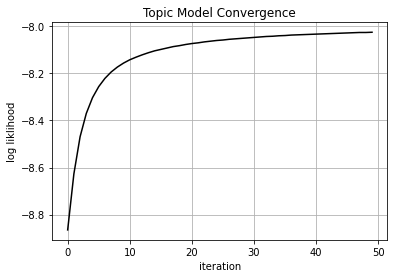

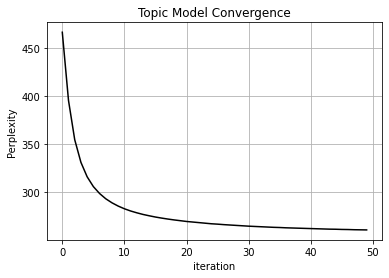

Note: Perplexity estimate based on a held-out corpus of 500 documents


In [13]:
p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim_lem.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)))
plt.plot(iter,liklihood,c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()

plt.plot(iter,perplexity,c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()
print('Note: Perplexity estimate based on a held-out corpus of 500 documents')

In [14]:
bound = lda_model_lemmatized.log_perplexity(corpus_lemmatized)
print('per-word ELBO (per-word likelihood bound): ', bound)
print('Perplexity: ', np.exp(-1. * bound))

per-word ELBO (per-word likelihood bound):  -8.024864438083464
Perplexity:  3056.0069915157906


In [15]:
coherence_model_lda = CoherenceModel(
   model=lda_model_lemmatized, texts=data_lemmatized, dictionary=id2word_lemmatized, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6008030011192694


In [16]:
pprint(lda_model_lemmatized.print_topics())

[(0,
  '0.030*"building" + 0.013*"house" + 0.010*"design" + 0.008*"site" + '
  '0.007*"construction" + 0.006*"floor" + 0.006*"room" + 0.006*"hospital" + '
  '0.005*"window" + 0.005*"street"'),
 (1,
  '0.039*"event" + 0.024*"championship" + 0.020*"compete" + 0.019*"woman" + '
  '0.016*"final" + 0.015*"competition" + 0.013*"finish" + 0.013*"title" + '
  '0.012*"round" + 0.011*"winner"'),
 (2,
  '0.052*"game" + 0.021*"player" + 0.011*"version" + 0.009*"character" + '
  '0.008*"computer" + 0.007*"card" + 0.006*"system" + 0.006*"design" + '
  '0.006*"video" + 0.005*"series"'),
 (3,
  '0.016*"village" + 0.013*"church" + 0.012*"century" + 0.011*"population" + '
  '0.009*"town" + 0.008*"region" + 0.007*"korean" + 0.007*"municipality" + '
  '0.007*"local" + 0.005*"country"'),
 (4,
  '0.023*"district" + 0.022*"county" + 0.014*"town" + 0.014*"park" + '
  '0.012*"river" + 0.011*"road" + 0.011*"population" + 0.010*"island" + '
  '0.009*"land" + 0.009*"community"'),
 (5,
  '0.047*"company" + 0.036*"

In [17]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmatized, corpus_lemmatized, id2word_lemmatized)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.075365 -0.067386       1        1  8.994434
12    -0.008911 -0.058414       2        1  7.252453
17     0.039706 -0.177694       3        1  6.906727
18     0.143512 -0.071474       4        1  6.881077
7     -0.089813  0.068186       5        1  6.872517
13     0.138920  0.188265       6        1  6.539053
14     0.050315 -0.108228       7        1  5.777704
3     -0.160374 -0.014842       8        1  5.529021
11     0.031457 -0.066751       9        1  5.463350
19     0.017349 -0.023810      10        1  5.327732
16     0.147772 -0.004753      11        1  4.832454
0     -0.172116  0.002122      12        1  4.541318
4     -0.243474  0.115325      13        1  4.328562
8     -0.055527 -0.010977      14        1  3.785976
10    -0.171762  0.016200      15        1  3.696517
15     0.042429 -0.122675      16        1  3.559619
9      0.137467 -0.070007      17        1  3.335193
2      0.055447 -0.011547      18        1  2.758155
1      0.144565  0.276897      19        1  2.181089
5      0.028402  0.141563      20        1  1.437050, topic_info=           Term         Freq        Total Category  logprob  loglift
903        film  3677.000000  3677.000000  Default  30.0000  30.0000
910        game  3736.000000  3736.000000  Default  29.0000  29.0000
112      season  3508.000000  3508.000000  Default  28.0000  28.0000
1356      album  2320.000000  2320.000000  Default  27.0000  27.0000
345     company  2674.000000  2674.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1998       road    85.317633  1266.873569  Topic20  -5.2869   1.5447
1301     market    64.996388   885.975941  Topic20  -5.5589   1.6302
2218   business    64.270323  1019.832035  Topic20  -5.5702   1.4783
2904      drive    62.140339   658.040963  Topic20  -5.6039   1.8827
1578  operation    60.388745   876.623751  Topic20  -5.6325   1.5673

[1566 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
9039      6  0.016704  abbey
9039      8  0.952151  abbey
9039     17  0.016704  abbey
4968      3  0.056534  abbot
4968      8  0.829166  abbot
...     ...       ...    ...
321      16  0.205640  young
321      17  0.078899  young
321      18  0.000839  young
321      19  0.010912  young
321      20  0.015948  young

[8459 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 13, 18, 19, 8, 14, 15, 4, 12, 20, 17, 1, 5, 9, 11, 16, 10, 3, 2, 6])

In [28]:
pyLDAvis.save_html(vis, 'lda_gensim.html')
pyLDAvis.save_json(vis, 'lda_gensim_data.json')

## Using our implementation of the Collapsed Gibbs Sampler for LDA
- slower since we do not have a multicore implementation

In [31]:
from src.lda import LDA

In [32]:
lda2 = LDA(corpus=corpus_lemmatized, num_topics=20, vocab_len=len(id2word_lemmatized), alpha=0.01, beta=0.01)
starttime=time.time()
lda2.fit(burnin=10,max_iter=40)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

starting burn in phase...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:27<00:00, 44.74s/it]


running sampler...


  2%|█████▎                                                                                                                                                                                                               | 1/40 [00:43<28:30, 43.86s/it]

iteration: 0 log_likelihood: -7237340.734690794 perplexity: 4.606732941421257e+203


 28%|██████████████████████████████████████████████████████████▎                                                                                                                                                         | 11/40 [08:03<21:13, 43.91s/it]

iteration: 10 log_likelihood: -6942551.856496281 perplexity: 2.3326287803744535e+195


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 21/40 [16:01<14:56, 47.19s/it]

iteration: 20 log_likelihood: -6804039.024338112 perplexity: 2.951250143143829e+191


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 31/40 [23:22<06:40, 44.52s/it]

iteration: 30 log_likelihood: -6722634.794834826 perplexity: 1.5109113529391845e+189


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [30:04<00:00, 45.10s/it]

Time taken = 38 minutes


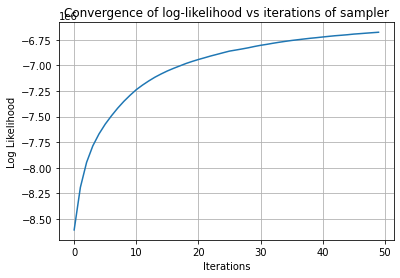

In [33]:
lda2.plot_log_likelihood()

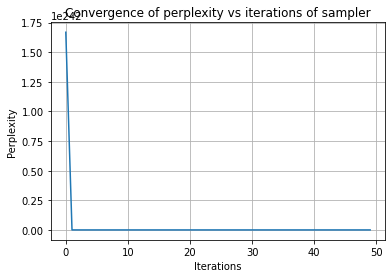

In [34]:
lda2.plot_perplexity()

In [35]:
lda2.print_topics(id2word_lemmatized, topn=10)

0 {'music': 0.009090064208092581, 'song': 0.00842271534697961, 'album': 0.008380566997856687, 'single': 0.006792979180893198, 'band': 0.0053318364112984835, 'perform': 0.004994649618315088, 'track': 0.004397548005740324, 'artist': 0.004250028783810089, 'tour': 0.004228954609248626, 'singer': 0.00407441066246457}


1 {'season': 0.011179759804528018, 'player': 0.00880397840883511, 'game': 0.00862122599378181, 'final': 0.007167152430531636, 'finish': 0.006976454258302105, 'football': 0.006912888200892262, 'championship': 0.006158041269150368, 'career': 0.005935560068215915, 'club': 0.005919668553863454, 'round': 0.005260170708236326}


2 {'refer': 0.003305126315452311, 'period': 0.003114711433386788, 'consider': 0.002971900271837646, 'often': 0.0029650997403353058, 'various': 0.002767884326767443, 'capture': 0.002720280606251062, 'accord': 0.0026046715707112806, 'rule': 0.0025842699762042604, 'order': 0.00254346678719022, 'similar': 0.0024686609406644787}


3 {'publish': 0.005075090202276

In [36]:
vis2 = lda2.plot_ldavis(id2word_lemmatized)

In [37]:
vis2

/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for al